In [1]:
import xgboost as xgb
import os
import seaborn as sns
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score
from time import time
from scipy import stats
import joblib
import pickle
import pylab as plt
from sklearn.model_selection import cross_val_score, GridSearchCV
import torch.nn as nn
import lightgbm as lgb
from utils import *


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(suppress=True)
sns.set_style({'font.sans-serif': ['simhei', 'Arial']})   # 解决画图中文乱码

%matplotlib inline

In [3]:
ts = time()
data = pd.read_csv('./data.csv', encoding='GBK')
print(time()-ts)
data.data_date = pd.to_datetime(data.data_date)
data.head(1)

0.17679738998413086


,id,site_id,asin,data_date,product_title,ordered_revenue,ordered_revenue_of_total,ordered_revenue_last_year,ordered_units,ordered_units_of_total,ordered_units_prior_period,ordered_units_last_year,subcategory_sales_rank,average_sales_price,average_sales_price_prior_period,glance_views,change_in_glance_view_prior_period,change_in_gv_last_year,conversion_rate,rep_oos,rep_oos_of_total,rep_oos_prior_period,lbb_price,create_time,update_time
0,1,eb766123-9f24-436e-9117-49c739816794,B07GJBBGHG,2021-01-02,COSORI 5.8QT Electric Hot Air Fryers Oven Oill...,153827.1800,0.1300,1.2600,1284,0.0600,-0.1300,1.2600,1.0000,119.8000,0.0000,40220.0000,0.0000,1.1900,0.0300,0.0200,0.1400,0.1500,0.0000,2021/1/4 6:48,2021/1/4 6:48


In [4]:
data.shape

(28901, 25)

In [3]:
alldata = data[(data.asin == 'B07PY5M579')][['data_date',
                                             'ordered_units']].sort_values('data_date')
alldata.shape

(626, 2)

In [4]:
alldata.head(2).append(alldata.tail(2))

,data_date,ordered_units
15969,2019-12-02,817
15933,2019-12-03,138
28661,2021-08-21,262
28843,2021-08-22,272


In [62]:
alldata.ordered_units.mean()

140.54500818330607

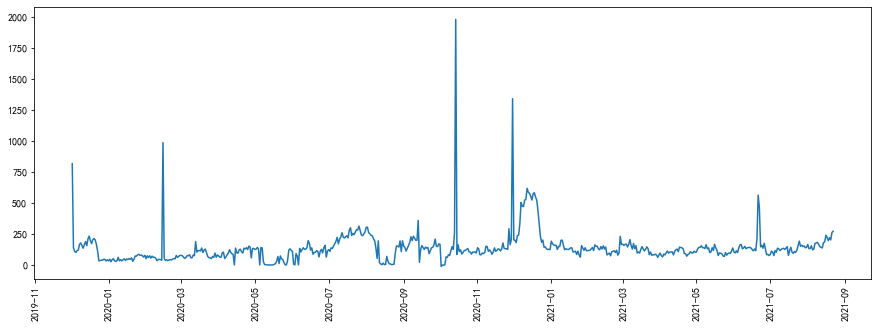

In [5]:
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
plt.plot(alldata.data_date, alldata.ordered_units)

<AxesSubplot:xlabel='ordered_units', ylabel='Density'>

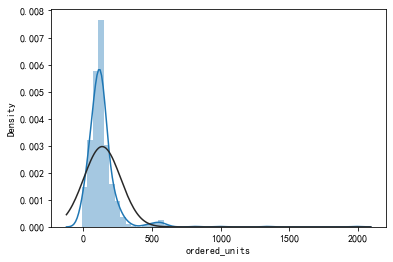

In [6]:
sns.distplot(alldata.ordered_units, fit=stats.norm)

In [7]:
alldata.ordered_units.skew(), np.log1p(alldata.ordered_units).skew()

(6.604530977788793, nan)

In [8]:
from scipy.special import boxcox1p
boxcox1p(alldata.ordered_units, 0.21).skew()

-1.0897947379933584

<AxesSubplot:xlabel='ordered_units', ylabel='Density'>

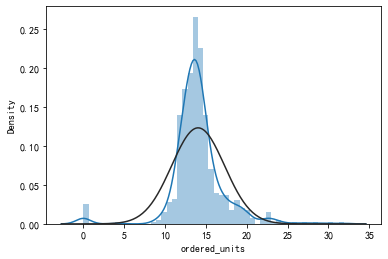

In [10]:
sns.distplot(boxcox1p(alldata.ordered_units, 0.21), fit=stats.norm)

## 数据预处理

### 异常值，删除小于等于0的数值和离群点

In [10]:
alldata[alldata.ordered_units <= 0]

,data_date,ordered_units
11251,2020-04-14,0
10477,2020-05-05,0
10254,2020-05-11,0
10219,2020-05-12,0
10185,2020-05-13,0
10147,2020-05-14,0
10108,2020-05-15,0
10071,2020-05-16,0
9647,2020-05-27,0
9375,2020-06-03,0


In [11]:
alldata.drop(alldata[alldata.ordered_units <= 0].index, inplace=True)

<AxesSubplot:xlabel='ordered_units'>

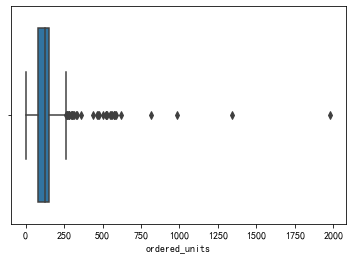

In [12]:
sns.boxplot(alldata.ordered_units)

In [13]:
alldata[alldata.ordered_units > 750].index

Int64Index([15969, 13379, 3880, 1681], dtype='int64')

In [14]:
alldata.drop(alldata[alldata.ordered_units > 5000].index, inplace=True)

In [15]:
alldata.shape

(611, 2)

### 设置样本权重

In [16]:
alldata['weight'] = alldata.data_date.apply(lambda x: (
    x - pd.to_datetime('2019-12-02')).days)

In [17]:
alldata.head(1)

,data_date,ordered_units,weight
15969,2019-12-02,817,0


### 缺失值

In [18]:
alldata.isnull().sum()

data_date        0
ordered_units    0
weight           0
dtype: int64

无缺失值不用处理

### 创造特征

In [19]:
def create_feature(df):
    df['year'] = df.data_date.dt.year
    df['month'] = df.data_date.dt.month
    df['day'] = df.data_date.dt.day
    df['weekday'] = df.data_date.dt.weekday  # 周几
    df['quarter'] = df.data_date.dt.quarter  # 季度
    df['weekofyear'] = df.data_date.dt.weekofyear

    df.drop('data_date', axis=1, inplace=True)
    return df

In [20]:
alldata = create_feature(alldata)

In [21]:
alldata.head(3)

,ordered_units,weight,year,month,day,weekday,quarter,weekofyear
15969,817,0,2019,12,2,0,4,49
15933,138,1,2019,12,3,1,4,49
15901,110,2,2019,12,4,2,4,49


In [22]:
x = alldata.drop('ordered_units', axis=1)
y = alldata['ordered_units']
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1)

In [23]:
x_train.head(2)

,weight,year,month,day,weekday,quarter,weekofyear
1439,369,2020,12,5,5,4,49
6329,260,2020,8,18,1,3,34


### 编码

In [24]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
x_train = encoder.fit_transform(x_train)
x_test = encoder.transform(x_test)
x_train.shape, x_test.shape

((549, 659), (62, 659))

## 训练

### sklearn api

In [27]:
ts = time()
print(cross_val_score(xgbr, x_train, y_train, cv=5).mean())
time() - ts

0.32000629278074316


1.9076037406921387

In [26]:
xgbr = XGBRegressor(n_estimators=200,
                    learning_rate=0.35,
                    max_depth=7,
                    subsample=0.6,
                    colsample_bytree=0.7,
                    objective='reg:squarederror',
                    base_score=0.5,
                    gamma=1,
                    n_jobs=8, verbosity=1)

xgbr.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)],
         early_stopping_rounds=20, verbose=True)

[0]	validation_0-rmse:152.25652	validation_1-rmse:128.04567
[1]	validation_0-rmse:122.60513	validation_1-rmse:99.60510
[2]	validation_0-rmse:103.10817	validation_1-rmse:87.05810
[3]	validation_0-rmse:88.02070	validation_1-rmse:79.72290
[4]	validation_0-rmse:78.92168	validation_1-rmse:72.91591
[5]	validation_0-rmse:71.84869	validation_1-rmse:67.97460
[6]	validation_0-rmse:63.84573	validation_1-rmse:66.23882
[7]	validation_0-rmse:57.97800	validation_1-rmse:61.87925
[8]	validation_0-rmse:53.66808	validation_1-rmse:60.23886
[9]	validation_0-rmse:50.37444	validation_1-rmse:58.64346
[10]	validation_0-rmse:47.69747	validation_1-rmse:55.11044
[11]	validation_0-rmse:45.64441	validation_1-rmse:53.58916
[12]	validation_0-rmse:43.82636	validation_1-rmse:53.01423
[13]	validation_0-rmse:42.46876	validation_1-rmse:52.62528
[14]	validation_0-rmse:41.25034	validation_1-rmse:51.70046
[15]	validation_0-rmse:39.95469	validation_1-rmse:49.50404
[16]	validation_0-rmse:38.16771	validation_1-rmse:47.09710
[17

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.35, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [ ]:
# 网格搜索
# params_grid = {'learning_rate': np.arange(0, 1, 0.05)}

# params_grid = {'max_depth': range(0, 8, 1)}

# params_grid = {'subsample': np.arange(0, 1, 0.05)}
params_grid = {'colsample_bytree': np.arange(0, 1, 0.05)}

gridCV = GridSearchCV(xgbr, params_grid, cv=5, scoring='r2', n_jobs=8)

ts = time()
gridCV.fit(x_train, y_train)
print(time() - ts)
gridCV.best_params_, gridCV.best_score_

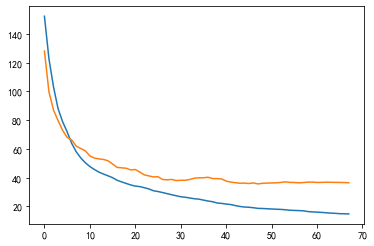

In [28]:
result = xgbr.evals_result()
plt.plot(result['validation_0']['rmse'])
plt.plot(result['validation_1']['rmse'])

### xgboost api

In [38]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

params = {'eta': 0.3,
          'objective': 'reg:squarederror',
          'gamma': 0,
          'max_depth': 5,
          'subsample': 0.5,
          'colsample_bytree': 1,
          'base_score': 0.5,
          'n_jobs': 8}

a = {}  # 记录验证集结果
model = xgb.train(params, dtrain, 300, early_stopping_rounds=20, evals=[
                  (dtest, 'test')], evals_result=a, verbose_eval=True)

[0]	test-rmse:787.05859
[1]	test-rmse:605.59271
[2]	test-rmse:535.71790
[3]	test-rmse:504.41638
[4]	test-rmse:451.57785
[5]	test-rmse:416.67691
[6]	test-rmse:368.91260
[7]	test-rmse:337.75443
[8]	test-rmse:336.24973
[9]	test-rmse:334.07410
[10]	test-rmse:320.31738
[11]	test-rmse:320.45258
[12]	test-rmse:305.20642
[13]	test-rmse:285.16476
[14]	test-rmse:286.65512
[15]	test-rmse:284.19476
[16]	test-rmse:284.05826
[17]	test-rmse:283.70371
[18]	test-rmse:279.53226
[19]	test-rmse:281.19687
[20]	test-rmse:277.47406
[21]	test-rmse:278.99527
[22]	test-rmse:273.31439
[23]	test-rmse:263.51685
[24]	test-rmse:261.43713
[25]	test-rmse:255.99350
[26]	test-rmse:256.36807
[27]	test-rmse:255.47286
[28]	test-rmse:254.09540
[29]	test-rmse:256.87180
[30]	test-rmse:258.02121
[31]	test-rmse:252.14825
[32]	test-rmse:259.23050
[33]	test-rmse:261.94702
[34]	test-rmse:259.51361
[35]	test-rmse:260.83997
[36]	test-rmse:257.71121
[37]	test-rmse:259.52267
[38]	test-rmse:266.07889
[39]	test-rmse:259.49432
[40]	test-

## 测试

### sklearn api

In [29]:
y_pred = xgbr.predict(x_test)
print('metrics1: {:.3f}\nmetrics2: {:.3f}\nr2: {:.3f}'.format(metrics1(y_test, y_pred),
                                                              metrics2(
                                                                  y_test, y_pred),
                                                              r2_score(y_test, y_pred)))

metrics1: 0.960
metrics2: 0.212
r2: 0.869


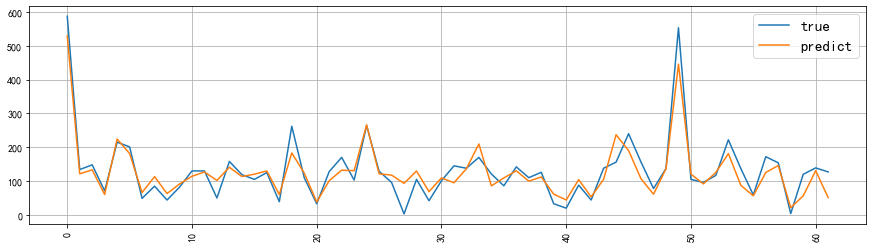

In [30]:
plt.figure(figsize=(15, 4))
plt.plot(y_test.values, label='true')
plt.plot(y_pred, label='predict')
plt.xticks(rotation=90)
plt.grid()
plt.legend(fontsize=15)

In [32]:
alldata.tail()

,ordered_units,weight,year,month,day,weekday,quarter,weekofyear
28721,196,625,2021,8,18,2,3,33
28601,221,626,2021,8,19,3,3,33
28541,202,627,2021,8,20,4,3,33
28661,262,628,2021,8,21,5,3,33
28843,272,629,2021,8,22,6,3,33


In [47]:
date_pred = pd.DataFrame({'data_date': pd.date_range('2021-8-23', periods=30)})

In [48]:
date_pred['weight'] = date_pred.data_date.apply(lambda x: (
    x - pd.to_datetime('2019-12-02')).days)

In [49]:
date_pred

,data_date,weight
0,2021-08-23,630
1,2021-08-24,631
2,2021-08-25,632
3,2021-08-26,633
4,2021-08-27,634
5,2021-08-28,635
6,2021-08-29,636
7,2021-08-30,637
8,2021-08-31,638
9,2021-09-01,639


In [42]:
create_feature(date_pred)

,weight,year,month,day,weekday,quarter,weekofyear
0,630,2021,8,23,0,3,34
1,631,2021,8,24,1,3,34
2,632,2021,8,25,2,3,34
3,633,2021,8,26,3,3,34
4,634,2021,8,27,4,3,34
5,635,2021,8,28,5,3,34
6,636,2021,8,29,6,3,34
7,637,2021,8,30,0,3,35
8,638,2021,8,31,1,3,35
9,639,2021,9,1,2,3,35


In [44]:
date_pred = encoder.transform(date_pred)

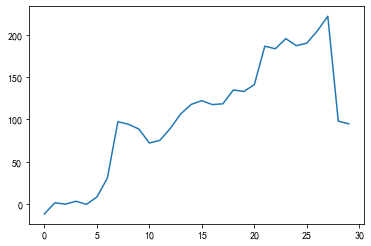

In [46]:
plt.plot(xgbr.predict(date_pred))

In [50]:
from sklearn.model_selection import TimeSeriesSplit

In [57]:
a = np.random.randn(10, 10)

In [60]:
tss = TimeSeriesSplit(n_splits=9)

In [61]:
for i in tss.split(a):
    print(i)

(array([0]), array([1]))
(array([0, 1]), array([2]))
(array([0, 1, 2]), array([3]))
(array([0, 1, 2, 3]), array([4]))
(array([0, 1, 2, 3, 4]), array([5]))
(array([0, 1, 2, 3, 4, 5]), array([6]))
(array([0, 1, 2, 3, 4, 5, 6]), array([7]))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([8]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([9]))


In [52]:
cross_val_score(xgbr, x_train, y_train, cv=tss, )

array([0.17525522, 0.01379453, 0.28492534, 0.68256663, 0.05468413])

### xgboost api

In [35]:
dtest = xgb.DMatrix(x_test, y_test)

In [36]:
y_pred = model.predict(dtest)
print('metrics1: {:.3f}\nmetrics2: {:.3f}\nr2: {:.3f}'.format(metrics1(y_test, y_pred),
                                                              metrics2(
                                                                  y_test, y_pred),
                                                              r2_score(y_test, y_pred)))

metrics1: 0.939
metrics2: 0.732
r2: 0.858


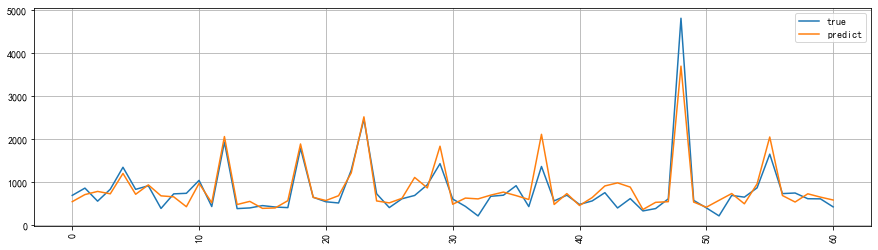

In [37]:
plt.figure(figsize=(15, 4))
plt.plot(y_test.values, label='true')
plt.plot(y_pred, label='predict')
plt.xticks(rotation=90)
plt.grid()
plt.legend()

In [ ]:
model.get_score(importance_type='gain')

In [ ]:
xgb.to_graphviz(model, num_trees=0)

In [ ]:
import xgboost
from xgboost import XGBClassifier
from sklearn.datasets import load_iris

iris = load_iris()
x, y = iris.data, iris.target
model = XGBClassifier()
model.fit(x, y)
# 如果输入是没有表头的array,会自动以f1,f2开始,需要更换表头
# 画树结构图的时候也需要替换表头

model.get_booster().feature_names = iris.feature_names
# max_num_features指定排名最靠前的多少特征
# height=0.2指定柱状图每个柱子的粗细,默认是0.2
# importance_type='weight'默认是用特征子树中的出现次数(被选择次数),还有"gain"和"cover"
xgboost.plot_importance(model, max_num_features=5, importance_type='gain')

# f_score就是feature score
model.feature_importances_  # 这里的特征重要性就是gain进行归一化之后的值

In [ ]:
model.feature_importances_.sum()

In [ ]:
2.9918/(2.9918+1.3149+0.0727+0.0424)

In [ ]:
xgb.to_graphviz(model, num_trees=1)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt = DecisionTreeClassifier(max_depth=2)

In [ ]:
dt.fit(x, y)

In [ ]:
import graphviz
from sklearn import tree
import pydotplus
from IPython.display import Image

In [ ]:
# 对于决策树来说，特征重要性就等于这个特征分裂的时候的总信息增益，这个特征有可能分裂，加到一起就行
dt.feature_importances_

In [ ]:
dot = tree.export_graphviz(dt)
graph = pydotplus.graph_from_dot_data(dot)
Image(graph.create_png())